<a href="https://colab.research.google.com/github/dbarrau/TensorFlow_training/blob/main/05_transfer_learning_tf_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using `tf.keras.applications.EfficientNetB0` as the base model. Use the `ModelCheckpoint` callback to save the weights to file.

In [ ]:
# Check for GPU usage
!nvidia-smi

Wed Jul 20 11:51:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import packages and helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-20 11:51:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-20 11:51:15 (111 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
import PIL
import numpy as np
from helper_functions import unzip_data, walk_through_dir



IMG_SIZE = (224, 224)
BATCH_SIZE = 32

### Collect and load data 

In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("/content/10_food_classes_10_percent.zip")

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

--2022-07-20 11:51:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.218.128, 108.177.12.128, 108.177.13.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   254MB/s    in 0.6s    

2022-07-20 11:51:19 (254 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Load data

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical")



Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Create base model



First we will create a data augmentation layer

In [ ]:
data_augmentation = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
], name="data_augmentation_layer")

Now we can create a model under the functional api

In [ ]:
# Setup input shape
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create inputs and outputs (and layers in between)
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs, training=False)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

### Create model checkpoint callback

In [ ]:
# Set checkpoint callback
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create ModelCheckpoint callback that saves model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

### Compile and fit the model

In [ ]:
# compile model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# fit model
initial_epochs = 10
history = model.fit(train_data_10_percent,
                    epochs=initial_epochs,
                    validation_data=test_data,
                    validation_steps=int(0.25*len(test_data)),
                    callbacks=[checkpoint_callback])

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.8584 - accuracy: 0.4187
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 198ms/step - loss: 1.8584 - accuracy: 0.4187 - val_loss: 1.3436 - val_accuracy: 0.6793
Epoch 2/10
23/24 [===========================>..] - ETA: 0s - loss: 1.1075 - accuracy: 0.7527
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 4s 142ms/step - loss: 1.1073 - accuracy: 0.7520 - val_loss: 0.9246 - val_accuracy: 0.7780
Epoch 3/10
23/24 [===========================>..] - ETA: 0s - loss: 0.8015 - accuracy: 0.8261
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 4s 143ms/step - loss: 0.8005 - accuracy: 0.8253 - val_loss: 0.7725 - val_accuracy: 0.8174
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.6488 - accuracy: 

In [ ]:
model.evaluate(test_data)

79/79 [==============================] - 6s 66ms/step - loss: 0.4987 - accuracy: 0.8504


[0.4986710846424103, 0.8503999710083008]

In [ ]:
model.load_weights(checkpoint_path)

## Fine-tuning of last 20 layers from the base model

In [ ]:
# layers from our model
model.layers

In [ ]:
for i, layer in enumerate(model.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

For finetuning, we to set the last 20 layers of our `base_model.trainable = True`

In [ ]:
base_model.trainable = True

# Freeze all layers in the base_model except for last 20:
for layer in base_model.layers[:-20]:
  layer.trainable = False

# Recompile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
fine_tune_epochs = initial_epochs + 10

history_fine_tuning = model.fit(train_data_10_percent,
                                epochs=fine_tune_epochs,
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                initial_epoch=history.epoch[-1])

Epoch 10/20
24/24 [==============================] - 11s 190ms/step - loss: 0.2638 - accuracy: 0.9413 - val_loss: 0.4998 - val_accuracy: 0.8207
Epoch 11/20
24/24 [==============================] - 4s 136ms/step - loss: 0.1438 - accuracy: 0.9733 - val_loss: 0.4269 - val_accuracy: 0.8503
Epoch 12/20
24/24 [==============================] - 4s 133ms/step - loss: 0.0903 - accuracy: 0.9840 - val_loss: 0.4540 - val_accuracy: 0.8421
Epoch 13/20
24/24 [==============================] - 4s 135ms/step - loss: 0.0564 - accuracy: 0.9947 - val_loss: 0.4512 - val_accuracy: 0.8405
Epoch 14/20
24/24 [==============================] - 4s 134ms/step - loss: 0.0370 - accuracy: 0.9987 - val_loss: 0.4568 - val_accuracy: 0.8503
Epoch 15/20
24/24 [==============================] - 4s 137ms/step - loss: 0.0210 - accuracy: 1.0000 - val_loss: 0.4887 - val_accuracy: 0.8470
Epoch 16/20
24/24 [==============================] - 4s 135ms/step - loss: 0.0149 - accuracy: 1.0000 - val_loss: 0.5286 - val_accuracy: 0.830

In [ ]:
def compare_histories(original_history, new_history, initial_epochs=10):
  """
  Compares two TensorFlow History objects
  """

  # Get original history measurements (Train)
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  # Get original history measurements (Validation data)
  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history with the new history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(8, 8));
  plt.subplot(2, 1, 1);
  plt.plot(total_acc, label="Training Loss");
  plt.plot(total_val_acc, label="Val Loss");
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning");
  plt.legend(loc="lower right");
  plt.title("Training and Validation Accuracy")

    # Make plot for loss
  plt.figure(figsize=(8, 8));
  plt.subplot(2, 1, 2);
  plt.plot(total_loss, label="Training Loss");
  plt.plot(total_val_loss, label="Val Loss");
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning");
  plt.legend(loc="upper right");
  plt.title("Training and Validation Loss")

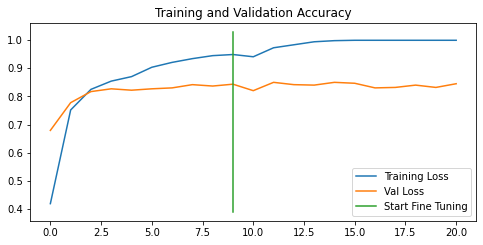

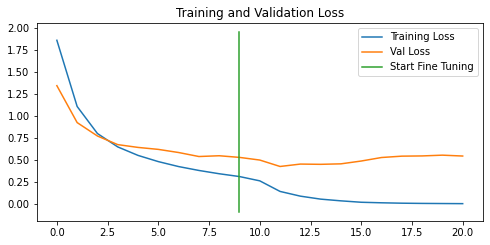

In [ ]:
compare_histories(history,history_fine_tuning)

## Finetuning last 30 layers from our base model

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-30]:
  layer.trainable = False

In [ ]:
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
# Restore extracted features
model.load_weights(checkpoint_path)

# Recompile model after setting last 30 layers to trainable
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

# fit model once more
history_last_30_finetuned = model.fit(train_data_10_percent,
                                      epochs=fine_tune_epochs,
                                      validation_data=test_data,
                                      validation_steps=int(0.25*len(test_data)),
                                      initial_epoch=history.epoch[-1])




Epoch 10/20
24/24 [==============================] - 10s 192ms/step - loss: 0.2496 - accuracy: 0.9467 - val_loss: 0.4334 - val_accuracy: 0.8520
Epoch 11/20
24/24 [==============================] - 4s 137ms/step - loss: 0.1326 - accuracy: 0.9720 - val_loss: 0.4503 - val_accuracy: 0.8470
Epoch 12/20
24/24 [==============================] - 4s 138ms/step - loss: 0.0715 - accuracy: 0.9933 - val_loss: 0.4678 - val_accuracy: 0.8536
Epoch 13/20
24/24 [==============================] - 4s 137ms/step - loss: 0.0405 - accuracy: 0.9960 - val_loss: 0.4887 - val_accuracy: 0.8438
Epoch 14/20
24/24 [==============================] - 4s 138ms/step - loss: 0.0220 - accuracy: 1.0000 - val_loss: 0.5150 - val_accuracy: 0.8289
Epoch 15/20
24/24 [==============================] - 4s 146ms/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.4728 - val_accuracy: 0.8454
Epoch 16/20
24/24 [==============================] - 4s 138ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.5463 - val_accuracy: 0.847

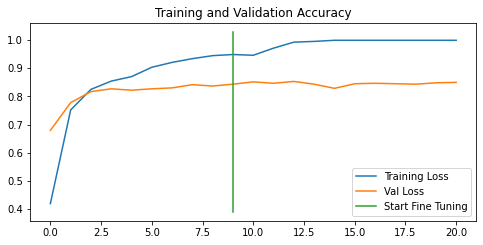

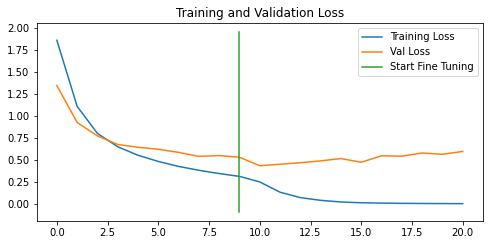

In [ ]:
compare_histories(history,history_last_30_finetuned)

In [ ]:
data_root_path = "10_food_classes_10_percent"


def load_random_image_file(model,data_root_path):
  """
    Takes an image and makes a prediction using a trained model.

    Args:

      model (tensorflow model): Trained tensorflow model
      data_root_path (str): Root path where train and test folders are located

    returns:
      Plot dispay (matplotlib.pyplot)


  """

  # Load list of the train and test folders 
  test_train_folders = os.listdir(data_root_path)

  # Randomly choose one of the two
  train_test_choice = random.choice(test_train_folders)

  # Get the list of category folders and randomly choose a category
  category_folders = sorted(os.listdir(data_root_path+"/"+train_test_choice))
  category_choice = random.choice(category_folders)

  # Set up the path to the random image file
  path_to_random_image = data_root_path+"/"+train_test_choice+"/"+category_choice

  # Retrieve filenames and choose a random one
  filenames = next(os.walk(path_to_random_image), (None, None, []))[2]
  image_choice = random.choice(filenames)

  # Instantiate the path to the randomly chosen image
  image_choice_path = path_to_random_image + "/" + image_choice

  # Loading the image
  img = tf.keras.utils.load_img(image_choice_path, target_size=(224,224))

  # Adapting the image as input to the model
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch


  pred = model.predict(img_array)

  pred_class = category_folders[tf.argmax(pred[0])]

  score = tf.reduce_max(pred[0])

  plt.figure(figsize=(6,6))
  plt.imshow(img);
  plt.axis("off")
  plt.title(f"True class: {category_choice} \n Predicted class: {pred_class} \n Confidence: {np.round(100*score)}%");
  

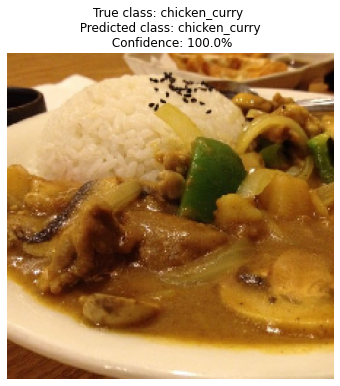

In [ ]:
load_random_image_file(model,data_root_path)